# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import h5py
import time

from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(2019)

# Helper Functions

0. Dataset

In [2]:
def load_data():
    train_dataset = h5py.File('./datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('./datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

1. Activation Functions

In [3]:
def sigmoid(Z):
    '''
    Implement the sigmoid activation function
    '''
    
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    
    return A, cache

In [4]:
def relu(Z):
    '''
    Implement the ReLU activation function
    '''
    
    A = np.maximum(0, Z)
    cache = Z
    
    # Assertion
    assert (A.shape == Z.shape)
    
    return A, cache

2. Derivatives of Activation

In [5]:
def sigmoid_backward(dA, cache):
    '''
    Implment the derivative dZ = dA * (dA/dZ) for sigmoid
    '''
    
    Z = cache
    
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    
    # Assertion
    assert (dZ.shape == Z.shape)
    
    return dZ

In [6]:
def relu_backward(dA, cache):
    '''
    Implement the derivative dZ = dA * (dA/dZ) for ReLU
    '''
    
    Z = cache
    
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0 ## when z <= 0, set dz = 0
    
    # Assertion
    assert (dZ.shape == Z.shape)
    
    return dZ

# Neural Network Blocks

1. Initializaiton

In [7]:
def initialize_params(layers_dims):
    '''
    layers_dims: python array (list), containing the dimensions of each layer 
                (including input layer)
    '''
    
    #np.random.seed(2019)
    params = {}
    L = len(layers_dims) - 1  ## L = number of layers
    
    # Loop for l=1 to L
    for l in range(1, L+1):
        params['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) / np.sqrt(layers_dims[l-1])
        params['b' + str(l)] = np.zeros((layers_dims[l], 1))
    
        ## Assertion
        assert (params['W' + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
        assert (params['b' + str(l)].shape == (layers_dims[l], 1))
    
    return params

2. Forward Propagation

In [8]:
def linear_forward(A_prev, W, b):
    '''
    Implement the linear step of forward propagation for a layer
    '''
    
    # Compute Z
    Z = np.dot(W, A_prev) + b
    
    # Assertion
    assert (Z.shape == (W.shape[0], A_prev.shape[1]))
    
    # Store cache
    cache = (A_prev, W, b)
    
    return Z, cache

In [9]:
def linear_activation_forward(A_prev, W, b, activation):
    '''
    Implement the forward propagation for a LINEAR->ACTIVATION layer  
    '''
    
    # For 'sigmoid'
    if activation == 'sigmoid':
        ## linear step
        Z, linear_cache = linear_forward(A_prev, W, b)
        ## activation step
        A, activation_cache = sigmoid(Z)
    
    # For 'relu'
    elif activation == 'relu':
        ## linear step
        Z, linear_cache = linear_forward(A_prev, W, b)
        ## activation step
        A, activation_cache = relu(Z)
    
    # Assertion
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    
    # Forward propagation cache
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [10]:
def L_model_forward(X, params):
    '''
    Implement the forward propagation for [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID layers 
    '''
    
    # Initialization
    caches = []
    A = X
    L = len(params) // 2  ## number of layers
    
    # Implement [LINEAR->RELU]*(L-1); Add cache to "caches" list
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, params['W' + str(l)], params['b' + str(l)], activation='relu')
        caches.append(cache)
    
    # Implement LINEAR->SIGMOID; Add cache to "caches" list
    AL, cache = linear_activation_forward(A, params['W' + str(L)], params['b' + str(L)], activation='sigmoid')
    caches.append(cache)
    
    # Assertion
    assert (AL.shape == (1, X.shape[1]))
    
    return AL, caches

3. Cost Function

In [11]:
def compute_cost(AL, Y):
    '''
    Compute cost function: cross-entropy
    '''
    
    # Compute cost
    m = Y.shape[1]
    cost = -1. / m * (np.dot(Y, np.log(AL).T) + np.dot(1 - Y, np.log(1 - AL).T))
    cost = np.squeeze(cost)  ## to make sure the cost is real number e.g. turns [[17]] into 17
    
    # Assertion
    assert (cost.shape == ())
    
    return cost

4. Backward Propagation

In [12]:
def activation_backward(dA, cache, activation):
    '''
    Implement the activation part for the backward propagation
    '''
    
    # For 'sigmoid'
    if activation == 'sigmoid':
        dZ = sigmoid_backward(dA, cache)
    
    # For 'relu'
    elif activation == 'relu':
        dZ = relu_backward(dA, cache)
    
    return dZ

In [13]:
def linear_activation_backward(dA, cache, activation):
    '''
    Implement the backward propagation for a LINEAR->ACTIVATION layer
    '''
    
    # Initialization
    linear_cache, activation_cache = cache
    A_prev, W, b = linear_cache
    m = A_prev.shape[1]
    
    # Compute gradients
    dZ = activation_backward(dA, activation_cache, activation)
    dW = 1. / m * np.dot(dZ, A_prev.T)
    db = 1. / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    # Assertion
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [14]:
def L_model_backward(AL, Y, caches):
    '''
    Implement the backward propagation for [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID layers 
    '''
    
    # Initialization
    grads = {}
    m = Y.shape[1]
    L = len(caches)  ## number of layers
    dAL = - np.divide(Y, AL) + np.divide(1 - Y, 1 - AL)  ## compute dAL initial
    
    # Implement SIGMOID->LINEAR (Lth layer); Add gradients to "grads" dictionary
    cache = caches[L-1]
    grads['dA' + str(L-1)], grads['dW' + str(L)], grads['db' + str(L)] = linear_activation_backward(dAL, cache, activation='sigmoid')
    
    # Implement [RELU->LINEAR]*(L-1); Add gradients to "grads" dictionary
    for l in reversed(range(L-1)):
        cache = caches[l]
        grads['dA' + str(l)], grads['dW' + str(l+1)], grads['db' + str(l+1)] = linear_activation_backward(grads["dA" + str(l+1)], cache, activation='relu')
    
    return grads

5. Update Parameters: Gradient Descent

In [15]:
def update_params(params, grads, lr):
    '''
    Implement Gradient Descent step to update parameters
    '''
    
    L = len(params) // 2  ## number of layers
    
    for l in range(L):
        params['W' + str(l+1)] = params['W' + str(l+1)] - lr * grads['dW' + str(l+1)]
        params['b' + str(l+1)] = params['b' + str(l+1)] - lr * grads['db' + str(l+1)]
    
    return params

6. Prediction

In [16]:
def predict(X, Y, params):
    # Initialization
    m = X.shape[1]
    
    # Forward propagation
    probas, caches = L_model_forward(X, params)
    
    # Convert probas to 0/1 predictions
    p = (probas > 0.5).astype(int)
    
    # Print accuracy
    print('Accuracy: ' + str(np.sum(p == Y) / m))
    
    return p

# Application
## Overview of the Data
- Load Data

In [17]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

- Overview

In [18]:
train_x_orig.shape, test_x_orig.shape

((209, 64, 64, 3), (50, 64, 64, 3))

In [19]:
train_y.shape, test_y.shape

((1, 209), (1, 50))

In [20]:
classes

array([b'non-cat', b'cat'], dtype='|S7')

- Example

y = 1. It's a cat picture.


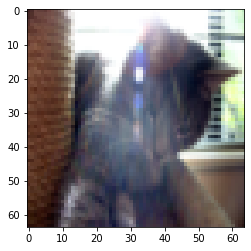

In [21]:
index = 42
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

## Preprocessing

1. Unrolling and Stacking instances in columns

In [22]:
m_train = train_x_orig.shape[0]
m_test = test_x_orig.shape[0]

In [23]:
train_x_flatten = train_x_orig.reshape(m_train, -1).T
test_x_flatten = test_x_orig.reshape(m_test, -1).T

2. Standardization

In [24]:
train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.

## 2-layer Neural Network

In [25]:
# Initialization
n_x = train_x.shape[0]
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [26]:
def two_layer_model(X, Y, layers_dims, lr=0.0075, epochs=3000, print_cost=False):
    # Initialzation
    np.random.seed(2019)
    grads = {}
    costs = []
    m = X.shape[1]
    
    # Initialize parameters
    params = initialize_params(layers_dims)
    
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    
    # Loop
    for i in range(epochs):
        
        # Foward propagation
        A1, cache1 = linear_activation_forward(X, W1, b1, activation='relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation='sigmoid')
        
        # Cost function
        cost = compute_cost(A2, Y)
        
        # Initialization for backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation='sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation='relu')
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters
        params = update_params(params, grads, lr)
        
        W1 = params["W1"]
        b1 = params["b1"]
        W2 = params["W2"]
        b2 = params["b2"]
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0:
            costs.append(cost)
            print("Cost after iteration {}: {}".format(i, cost))
    
    # Plot the costs vs iterations
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title('Learning rate = ' + str(lr))
    plt.show()
    
    return params

Cost after iteration 0: 0.6937692479861585
Cost after iteration 100: 0.5308767256352307
Cost after iteration 200: 0.43550322575893313
Cost after iteration 300: 0.3814091967146973
Cost after iteration 400: 0.3257074331071684
Cost after iteration 500: 0.26945856520526135
Cost after iteration 600: 0.2370774358691404
Cost after iteration 700: 0.17924593161862146
Cost after iteration 800: 0.12591570374569735
Cost after iteration 900: 0.10711841750156322
Cost after iteration 1000: 0.08637288882331938
Cost after iteration 1100: 0.07084538425864784
Cost after iteration 1200: 0.06066615562808675
Cost after iteration 1300: 0.05175426826922089
Cost after iteration 1400: 0.04505107935175396
Cost after iteration 1500: 0.039637095241411235
Cost after iteration 1600: 0.03516998992587707
Cost after iteration 1700: 0.03142948833179869
Cost after iteration 1800: 0.028304157878345452
Cost after iteration 1900: 0.025649095618475486
Cost after iteration 2000: 0.02337521110807613
Cost after iteration 2100: 

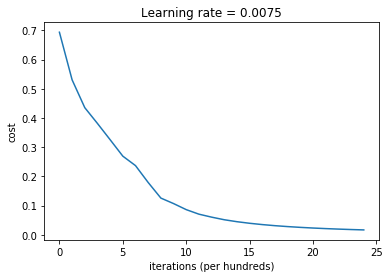

In [27]:
# Train 2-layer model
params_2 = two_layer_model(train_x, train_y, layers_dims, epochs=2500, print_cost=True)

In [28]:
# Predictions for training set
pred_train_2 = predict(train_x, train_y, params_2)

Accuracy: 1.0


In [29]:
# Preditcions for test set
pred_test_2 = predict(test_x, test_y, params_2)

Accuracy: 0.76


## L-layer Neural Network

In [30]:
# Initialization
layers_dims = (train_x.shape[0], 20, 7, 5, 1)  ## 4-layer model

In [31]:
def L_layer_model(X, Y, layers_dims, lr=0.0075, epochs=3000, print_cost=False):
    # Initialization
    np.random.seed(2019)
    costs = []
    
    # Initialize parameters
    params = initialize_params(layers_dims)
    
    # Loop
    for i in range(epochs):
        # Forward propagation
        AL, caches = L_model_forward(X, params)
        
        # Cost function
        cost = compute_cost(AL, Y)
        
        # Backward propagation
        grads = L_model_backward(AL, Y, caches)
        
        # Update parameters
        params = update_params(params, grads, lr)
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0:
            costs.append(cost)
            print("Cost after iteration {}: {}".format(i, cost))
    
    # Plot the costs vs iterations
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(lr))
    plt.show()
    
    return params

Cost after iteration 0: 0.6933663129300723
Cost after iteration 100: 0.6065552407924525
Cost after iteration 200: 0.5481601219779865
Cost after iteration 300: 0.4840318903695298
Cost after iteration 400: 0.45038393372714874
Cost after iteration 500: 0.39196079732654
Cost after iteration 600: 0.3380100980102377
Cost after iteration 700: 0.25128622025791314
Cost after iteration 800: 0.17888634503695822
Cost after iteration 900: 0.12833913750000772
Cost after iteration 1000: 0.07617339973796591
Cost after iteration 1100: 0.038091754947786396
Cost after iteration 1200: 0.02546666680739256
Cost after iteration 1300: 0.018722541461427274
Cost after iteration 1400: 0.014433759683774087
Cost after iteration 1500: 0.011529330250764074
Cost after iteration 1600: 0.009473239540779261
Cost after iteration 1700: 0.007958011273692387
Cost after iteration 1800: 0.006807420197075814
Cost after iteration 1900: 0.0059087753162281285
Cost after iteration 2000: 0.005189373737518614
Cost after iteration 21

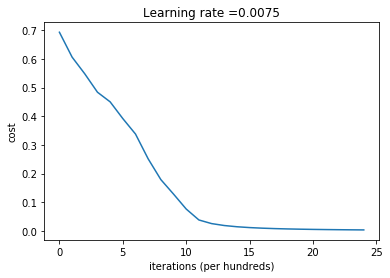

In [34]:
# Train L-layer model
params_L = L_layer_model(train_x, train_y, layers_dims, epochs=2500, print_cost=True)

In [35]:
# Predictions for training set
pred_train_L = predict(train_x, train_y, params_L)

Accuracy: 1.0


In [36]:
# Predictions for test set
pred_test_L = predict(test_x, test_y, params_L)

Accuracy: 0.78
